In [74]:
import networkx as nx
import ast
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [75]:
g = nx.read_gml('testCinfExport.gml')

In [76]:
nx.to_dict_of_dicts(g)

{'[1, 2, 3]': {'[2, 1, 3]': {'weight': '[[1, 0, 0], [0, 0, 0]]'},
  '[1, 3, 2]': {'weight': '[[0, 1, 0], [0, 0, 0]]'},
  '[3, 2, 1]': {'weight': '[[0, 0, 1], [0, 0, 0]]'}},
 '[2, 1, 3]': {'[1, 2, 3]': {'weight': '[[0, 0, 0], [0, 0, 1]]'},
  '[2, 3, 1]': {'weight': '[[0, 0, 1], [0, 0, 0]]'},
  '[3, 1, 2]': {'weight': '[[0, 1, 0], [1, 0, 0]]'}},
 '[2, 3, 1]': {'[3, 2, 1]': {'weight': '[[0, 0, 0], [1, 0, 0]]'},
  '[2, 1, 3]': {'weight': '[[0, 0, 0], [0, 1, 0]]'},
  '[1, 3, 2]': {'weight': '[[0, 0, 0], [0, 0, 1]]'}},
 '[3, 2, 1]': {'[2, 3, 1]': {'weight': '[[0, 1, 0], [0, 0, 0]]'},
  '[3, 1, 2]': {'weight': '[[1, 0, 0], [0, 0, 1]]'},
  '[1, 2, 3]': {'weight': '[[0, 0, 0], [0, 1, 0]]'}},
 '[3, 1, 2]': {'[1, 3, 2]': {'weight': '[[0, 0, 0], [0, 0, 0]]'},
  '[3, 2, 1]': {'weight': '[[0, 0, 0], [0, 0, 0]]'},
  '[2, 1, 3]': {'weight': '[[0, 0, 0], [0, 0, 0]]'}},
 '[1, 3, 2]': {'[3, 1, 2]': {'weight': '[[0, 0, 1], [0, 1, 0]]'},
  '[1, 2, 3]': {'weight': '[[0, 0, 0], [1, 0, 0]]'},
  '[2, 3, 1]': {

In [80]:
def convert_gml(fileName): #GridToolsTBD exports to a text file - this grabs it and converts the edges back to lists
                           #super inneficient - should convert to pickle file system or something
    g = nx.read_gml(fileName)
    for edge in g.edges:
        g[edge[0]][edge[1]]['diffweight'] = ast.literal_eval(g[edge[0]][edge[1]]['weight'])
        g[edge[0]][edge[1]]['diffweight'] = g[edge[0]][edge[1]]['diffweight'][0]+g[edge[0]][edge[1]]['diffweight'][1] #end result is edge weights as list of
                                                                                                          #multiplicities [U1,U2...,Un,V1,...,Vn]
    return g

def construct_sageG_cinf(g, size = -1): #Construct CFKinf complex from graph data - essentially just changing weights to polynomials
                                  #Only works for grid diagrams *not* Latin Squares
    if size == -1:
        size = len(g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['diffweight'])  #kind of a mess - just turning the edges
    n = size/2                                                                              #into a list and checking the length of
                                                                                            #the weight of the first edge
    F,Vars = cinf_coeff(n)
    resG = DiGraph()
    for edge in g.edges:
        
        start = edge[0]
        end = edge[1]
        poly = F(1)
        i = 0
        for entry in g[edge[0]][edge[1]]['diffweight']:
            
            poly = poly*(Vars[i])**entry
            i = i + 1
            
        resG.add_edge(start, end, poly)
        
    return resG

def construct_cinf(g, size = -1): #Construct CFKinf complex from graph data - essentially just changing weights to polynomials
                                  #Only works for grid diagrams *not* Latin Squares
    if size == -1:
        size = len(g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['diffweight'])  #kind of a mess - just turning the edges
    n = size/2                                                                              #into a list and checking the length of
                                                                                            #the weight of the first edge
    F,Vars = cinf_coeff(n)
    resG = nx.DiGraph()
    for edge in g.edges:
        
        start = edge[0]
        end = edge[1]
        poly = F(1)
        i = 0
        for entry in g[edge[0]][edge[1]]['diffweight']:
            
            poly = poly*(Vars[i])**entry
            i = i + 1
            
        resG.add_edge(start,end,diffweight = poly)
        
    return resG
        
def cinf_coeff(size):
    n = size
    preF = LaurentPolynomialRing(GF(2), 'U', n) #F[Ui+-] which we'll then pair up with the Vi
    preF.inject_variables()                     #Telling Sage we have Ui's as variables
    Vars = preF.gens()                          #storing the variables in a list - not currently implemented anywhere
    for vari in preF.gens():
        preF.<vari> = preF
    F = LaurentPolynomialRing(preF, 'V', n)     #Takes our preF (F[Ui+-]) and adjoins Vi
    F.inject_variables()                        #F only thinks it has Vi as variables, we tell Sage about it
    Vars = Vars + F.gens()
    for vari in F.gens():
        F.<vari> = F
#     for vari in Vars: 
#         F.<vari> = F    
    return F,Vars

def find_one(targetlist): #Searches a list for first 1 - will be used for reduction
#     print("searching for 1 in" + str(targetlist))
    if 1 in list(targetlist):
#         print("found 1 in the list at" + str(list(targetlist).index(1)))
        return list(targetlist).index(1)
    return -1

def find_col_with_one(matrix, startc=0):
    endc = len(matrix[0])
    print(str(endc))
    for n in range(startc, endc):
        
        search_result = find_one(matrix[:][n])
        if search_result != -1: return (search_result, n)
        
    return (-1, -1)


def reduction_remap(matrix, row, col):
    n = len(matrix[0])
    range1 = range_skip_entry(n, row)
#     print("searching through " + str(range1))
    for count, target_row in enumerate(range1):
        
        entry = matrix[target_row][col]
        if entry != 0: my_row_add(matrix, row, target_row, entry)
            
    return matrix

def row_col_del(matrix, loc):
    newrange = list(range(len(matrix[0])))
    del newrange[loc]
    return matrix[newrange,newrange]

def range_skip_entry(n, skip):
    u = []
    for i in range(0, skip): u.append(i)
    for j in range(skip+1, n): u.append(j)       
    return u

def reduction(matrix):
    col, row = find_col_with_one(matrix)
#     print("reducing around entry " +str(row) + "," +str(col))
    if col == -1:
        
        print("completed reduction")
        print(matrix)
        print (type(matrix))
        return matrix
    
    print("reduction in progress")
    remapped_matrix = reduction_remap(matrix, row, col)
    if row < col:
        
        remapped_matrix = row_col_del(remapped_matrix, col)
        remapped_matrix = row_col_del(remapped_matrix, row)
        
    else:
        
        remapped_matrix = row_col_del(remapped_matrix, row)
        remapped_matrix = row_col_del(remapped_matrix, col)
        
    return reduction(remapped_matrix)
    
def my_row_add(matrix, row, targetrow, multiple):
    n = len(matrix[0])
    for i in range(n):
        current_src = matrix[row][i]
        if current_src != 0:
#             print("adding copies times " + str(current_src))
#             print("multiple" + str(multiple))
#             print("target entry " + str(matrix[targetrow][i]))
            matrix[targetrow,i] = matrix[targetrow][i] + multiple*current_src
#         print(matrix)
    return matrix
        

iterate through dictionary keys(dict)
    tracker = -1
    for target in keydic
        if target weight == 1
            graph reduction alg
            tracker = 1
    if tracker == 1
        return rerun
    else
        return
        
graph reduction(dict, key, target)
    for x in predecessors(target)
        if x == key: continue
        for y in successors(key)
            if y == target: continue
            x_weight = thegraph[x][targ]['weight']
            y_weight = thegraph[key][y]['weight']
            W = x_weight x y_weight
            add edge to graph from x to y weight = W
    delete key
    delete target
    return graph

In [93]:
def graph_red_search(given_graph): 
#searches through a cfk inf complex for reducible edges and calling
#the reduction function to eliminate the pair according to the reduction algorithm
#     dict_graph = nx.to_dict_of_dicts(given_graph)
    for key in given_graph:
        
        for target in given_graph[key]:
            
            if given_graph[key][target]['diffweight'] == 1:
                given_graph = graph_reduction(given_graph, key, target)
                return graph_red_search(given_graph)
            
    return given_graph

def graph_reduction(given_graph, key, target):
#Deletes edge specified from graph_red_search and adds in edges according to the
#reduction algorithm
    for x in given_graph.predecessors(target):
        
        if x == key: continue
        for y in given_graph.successors(key):
        
            if y == target: continue
            x_weight = given_graph[x][target]['diffweight']
            y_weight = given_graph[key][y]['diffweight']
            red_weight = x_weight * y_weight
            given_graph.add_edge(x,y,diffweight=red_weight)

    given_graph.remove_node(key)
    given_graph.remove_node(target)
    return given_graph



In [47]:
thering = cinf_coeff(3)

Defining U0, U1, U2
Defining V0, V1, V2


In [48]:
print(varis)

NameError: name 'varis' is not defined

In [49]:
f = thering
for vari in varis:
    f.<vari> = f

NameError: name 'varis' is not defined

In [50]:
g = U0*U1

In [51]:
g

U0*U1

In [70]:
g.subs(U0=U1)

U1^2

In [43]:
print(varis)

NameError: name 'varis' is not defined

In [90]:
g = convert_gml('testCinfExport.gml')
sageG = construct_sageG_cinf(g)
dictg = nx.to_dict_of_dicts(g)
# newg = DiGraph()
#graphs.graph_input.from_dict_of_dicts(dictg, weighted = True)
# newg
myf = sageG.weighted_adjacency_matrix()

Defining U0, U1, U2, U3, U4
Defining V0, V1, V2, V3, V4


In [105]:
nxG = construct_cinf(g)

Defining U0, U1, U2, U3, U4
Defining V0, V1, V2, V3, V4


In [106]:
resg = graph_red_search(nxG)

In [108]:
for x,y in resg.edges():
    print(x)
    resg[x][y]['diffweight'] = resg[x][y]['diffweight'].subs(V1=V0,V2=V0,V3=V0,V4=V0,U1=U0,U2=U0,U3=U0,U4=U0)
    if resg[x][y]['diffweight'] == 0:
        resg.remove_edge[x][y]

[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[1, 3, 4, 5, 2]
[1, 3, 4

In [111]:
myring = LaurentPolynomialRing(QQ, ('x','y'))

[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[5, 1, 3, 2, 4]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 4, 3, 5, 1]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[2, 5, 3, 1, 4]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[1, 4, 2, 5, 3]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[3, 2, 4, 5, 1]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[5, 2, 4, 1, 3]
[1, 3, 4, 5, 2]
[1, 3, 4

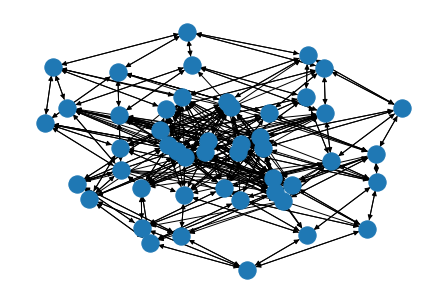

In [109]:
nx.draw(resg)
for x,y in resg.edges():
    print(x)
    resg[x][y]['diffweight'] = str(resg[x][y]['diffweight'])
nx.write_gml(resg, 'pleasegod.gml')

In [59]:
nxcomp = nx.DiGraph(dictg)

In [73]:
redg = graph_red_search(nxcomp)
for edge in redg.edges():
    redg

TypeError: 'tuple' object does not support item assignment

In [63]:
testg = 0

In [64]:
testg = nx.DiGraph()

In [65]:
testg.add_edge('x','y',diffweight = 'U0')

In [69]:
testg.edges()

OutEdgeView([('x', 'y')])

In [72]:
testg['x']['y']['diffweight']

'U0'

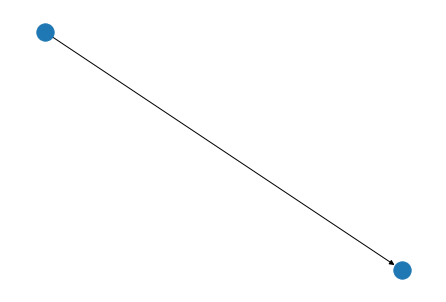

In [66]:
nx.draw(testg)

In [24]:
len(('x','y',U0))

3

ValueError: setting an array element with a sequence.

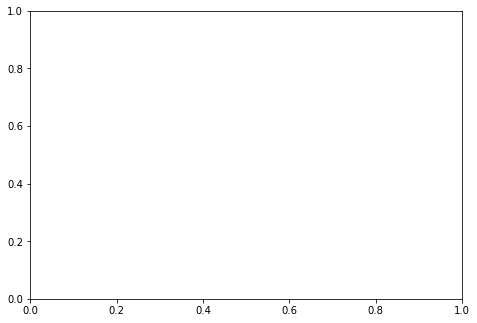

In [19]:
nx.draw(redg)

In [78]:
fun = U0*U2*V1

In [79]:
fun.subs(U0=U1)

U0*U2*V1

In [74]:
redg = reduction(myf.subs(V1=V0,V2=V0,U1=U0,U2=U0))

6
reduction in progress
4
completed reduction
[      0 U0 + U1       0 U1 + U2]
[     V0       0      U2       0]
[      0       0       0       0]
[     V0       0      U1       0]
<class 'sage.matrix.matrix_generic_sparse.Matrix_generic_sparse'>


In [77]:
redg.subs(U0=U1)

[      0 U0 + U1       0 U1 + U2]
[     V0       0      U2       0]
[      0       0       0       0]
[     V0       0      U1       0]

In [24]:
print(redg.subs(V1=V0,V2=V0,V3=V0,V4=V0,U1=U0,U2=U0,U3=U0,U4=U0))

[           0           V0           V0            0            0            0            0            0            0           U1            0            0            0            0           V0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0           V0            0            0            0]
[          U4            0            0            0            0            0           V0            0            0            0           U1            0            0            0            0           V0            0            0            0            0            0            0            0            0            0            0            0            0          

In [26]:
redg.subs(V1=1)

[      0 U0 + U1       0 U1 + U2]
[     V2       0      U2       0]
[      0  V2 + 1       0 V0 + V2]
[      1       0      U1       0]

In [36]:
nxg = sageG.networkx_graph()

In [60]:
redg = graph_red_search(nxg)

In [61]:
redg.edges()

OutEdgeView([('[1, 2, 3]', '[2, 1, 3]'), ('[1, 2, 3]', '[1, 3, 2]'), ('[2, 1, 3]', '[1, 2, 3]'), ('[2, 1, 3]', '[2, 3, 1]'), ('[1, 3, 2]', '[1, 2, 3]'), ('[1, 3, 2]', '[2, 3, 1]'), ('[2, 3, 1]', '[2, 1, 3]'), ('[2, 3, 1]', '[1, 3, 2]')])

In [62]:
redg.nodes()

NodeView(('[1, 2, 3]', '[2, 1, 3]', '[1, 3, 2]', '[2, 3, 1]'))

In [64]:
redg.get_edge_data('[1, 2, 3]', '[2, 1, 3]')

{'weight': U0}

In [55]:
g

In [61]:
testmat = matrix([[1,0,U1],[V0,1,V2],[U0,U1,V2]])
testmat

[ 1  0 U1]
[V0  1 V2]
[U0 U1 V2]

In [107]:
myf.add_multiple_of_row(1,2,U1)

In [33]:
g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['weight']

[1, 0, 0, 0, 0, 0]

In [98]:
preF = LaurentPolynomialRing(GF(2), 4, ('w'))
preF.inject_variables()
F = LaurentPolynomialRing(preF,4,'z')
F.inject_variables()
F.gens()[0]

Defining w0, w1, w2, w3
Defining z0, z1, z2, z3


z0

In [165]:
preF = LaurentPolynomialRing(GF(2), 'U', 3)
preF.inject_variables()
F = LaurentPolynomialRing(GF(2), 'V', 3)
F.inject_variables()

Defining U0, U1, U2
Defining V0, V1, V2


In [ ]:
#OLD CODE

# def reduce_around(M, position): 
# #M isa matrix and position is a pair [a,b] where a 1 is located
# #function does Gauss-Jordan-ish elimination on that column and in a symmetric way to the entry's row
#     a,b = position
#     #First step is to use the row to cancel the other entries, then we'll do a symmetric cancellation on
#     #the columns as well
#     column = M[:][b]
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != a) and (entry != 0)):
#             M.add_multiple_of_row(index, entry, a)
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != a) and (entry != 0)):
#             M.add_multiple_of_col(index, entry, b)
#     #Now we'll repeat the process but with the row entries
#     row = M[a][:]
#     for index, entry in enumerate(row):
#         if ((index != 0) and (index != b) and (entry != 0)):
#             M.add_multiple_of_col(index, entry, b)
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != b) and (entry != 0)):
#             M.add_multiple_of_row(index, entry, a)
#     return

# def hom_reduction(adj_mat):
#     M = adj_mat
#     row_position = 0
#     for row in M:
#         check, column_position = row_count(row)
#         if row_count(check[0]) > 1:
#             reduce_around(M, row_position, column_position)
#         row_position = position + 1